In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import ttest_ind
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
import itertools
import math 
import re
from collections import defaultdict
import missingno as msno
from sklearn.impute import KNNImputer, SimpleImputer
from scipy import stats
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from scipy.stats import mannwhitneyu
import itertools
from sklearn.preprocessing import QuantileTransformer
import optuna
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\sahan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
df_train = pd.read_csv("train_cleaned.csv") # 53,9
df_test = pd.read_csv("test_cleaned.csv")   # 52,9


In [9]:
df_train.head()
df_test.head()

id  emotional_charge_2  groove_efficiency_1  beat_frequency_1  \
0  25174            0.600480             1.543590           124.008   
1  38453                 NaN             0.722420           129.942   
2  29013            0.461916             0.757962            83.000   
3  57463            0.144236             0.923977           183.991   
4  51264            0.629832             1.473795           201.277   

   organic_texture_2 composition_label_0  harmonic_scale_1  intensity_index_0  \
0             0.0729                Dr.Q               1.0              0.763   
1             0.0105       Start A Party              11.0              0.801   
2             0.2700      Sombras - Live               2.0              0.561   
3             0.1210        Tennis Court               2.0                NaN   
4             0.0610  La Cumbia Del Lazo              10.0              0.716   

   duration_ms_0  album_name_length  ...  emotional_resonance_2  \
0        23032.0                4.0  ...                  0.834   
1       215466.0               20.0  ...                  0.216   
2       252261.0               44.0  ...                  0.546   
3       198907.0               23.0  ...                  0.337   
4       158720.0                NaN  ...                  0.966   

   time_signature_0  duration_ms_1 harmonic_scale_0 time_signature_2  \
0               4.0       253987.0              4.0              4.0   
1               4.0       267626.0              5.0              4.0   
2               4.0       226626.0              0.0              4.0   
3               4.0       234286.0              0.0              4.0   
4               4.0       188520.0              8.0              4.0   

  rhythmic_cohesion_2  emotional_resonance_0  harmonic_scale_2  \
0               0.604                 0.2050               0.0   
1               0.881                 0.2610               1.0   
2               0.555                 0.0555               0.0   
3               0.674                 0.4040               7.0   
4               0.511                 0.9620              10.0   

   intensity_index_2  instrumental_density_0  
0              0.720                0.165000  
1              0.496                0.000000  
2              0.846                0.002760  
3              0.428                0.000194  
4              0.652                0.000115  

[5 rows x 61 columns]

In [6]:
def reorder_columns(df):
    # Put these columns at the very start
    front_cols = ['id', 'track_identifier', 'creator_collective', 'publication_timestamp', 'album_component_count']
    
    # Preferred prefix ordering (next after front_cols)
    ordered_prefixes = [
        'composition_label', 'duration_ms', 'rhythmic_cohesion', 'intensity_index',
        'harmonic_scale', 'tonal_mode', 'organic_texture', 'beat_frequency',
        'time_signature', 'emotional_charge', 'groove_efficiency',
        'organic_immersion', 'duration_consistency', 'tempo_volatility',
        'key_variety', 'album_name_length', 'artist_count',
        'weekday_of_release', 'season_of_release', 'lunar_phase'
    ]

    # Group all columns by prefix
    grouped = defaultdict(list)
    for col in df.columns:
        match = re.match(r'^(.+?)_(\d)$', col)
        if match:
            base, suffix = match.groups()
            grouped[base].append((col, int(suffix)))
        else:
            grouped[col].append((col, -1))  # For unnumbered columns

    # Start with front_cols if they exist
    new_order = [col for col in front_cols if col in df.columns]
    used = set(new_order)

    # Add preferred grouped prefixes
    for prefix in ordered_prefixes:
        if prefix in grouped:
            sorted_group = [col for col, _ in sorted(grouped[prefix], key=lambda x: x[1])]
            new_order.extend(sorted_group)
            used.update(sorted_group)

    # Add remaining grouped prefixes not in preferred list
    for prefix in grouped:
        if prefix not in ordered_prefixes and prefix not in front_cols:
            sorted_group = [col for col, _ in sorted(grouped[prefix], key=lambda x: x[1])]
            new_order.extend(sorted_group)
            used.update(sorted_group)

    # Add any leftover columns (e.g., target) not yet added
    for col in df.columns:
        if col not in used:
            new_order.append(col)

    return df[new_order]
def plot_missing_values(df):
    msno.matrix(df)
    plt.show()
df_train = reorder_columns(df_train)
df_test = reorder_columns(df_test)

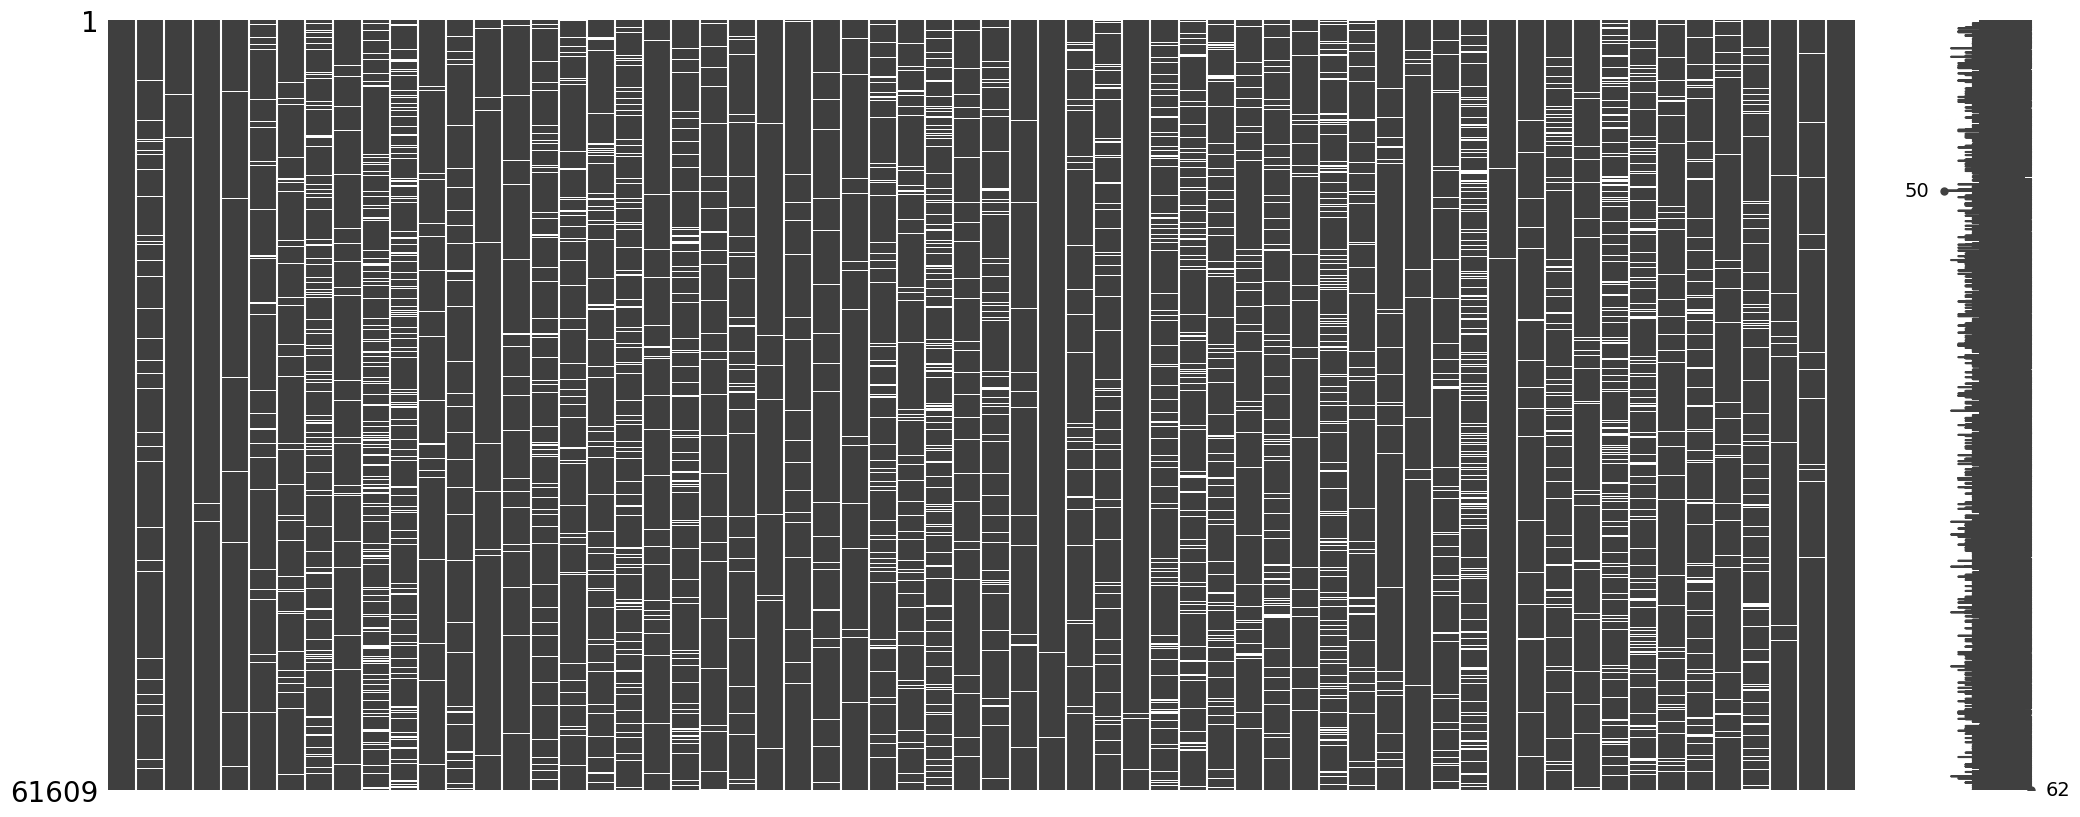

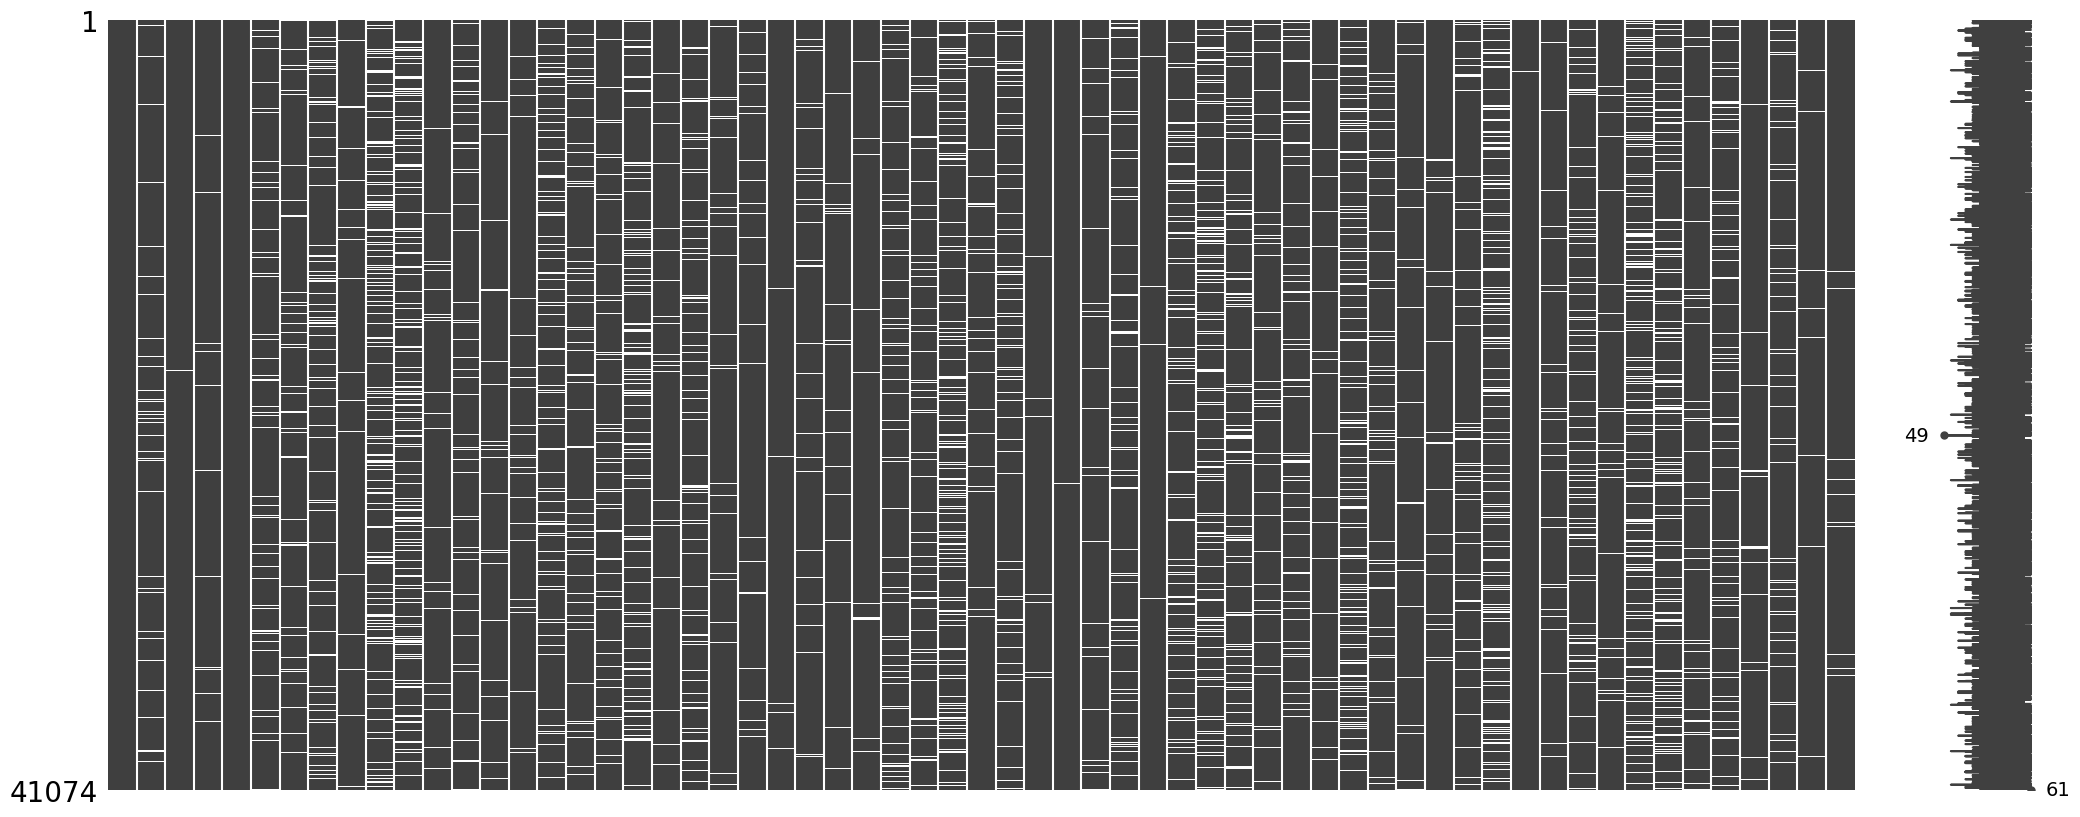

In [10]:
plot_missing_values(df_train)
plot_missing_values(df_test)

# EDA

In [16]:
def plot_all_numerical_distributions(df):
    df = df.drop(columns=['id'], errors='ignore')
    num_cols = df.select_dtypes(include=['number']).columns

    cols_in_row = 4
    total = len(num_cols)
    rows = (total + cols_in_row - 1) // cols_in_row

    fig, axes = plt.subplots(rows, cols_in_row, figsize=(cols_in_row * 4, rows * 3))
    axes = axes.flatten()

    for i, col in enumerate(num_cols):
        # Plot the histogram in blue
        sns.histplot(df[col], ax=axes[i], kde=False, bins=30, stat='count', color='blue')

        # Set the title
        axes[i].set_title(col)

    # Turn off unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
def get_categorical_value_counts(df):
   cat_columns = df.select_dtypes(include=['object', 'category']).columns
   result = {}
   
   for col in cat_columns:
       result[col] = df[col].nunique()
   
   return result    
def plot_specific_categorical_columns(df, figsize=(15, 12)):
    import matplotlib.pyplot as plt

    plt.close('all')

    specific_columns = ['weekday_of_release', 'season_of_release', 'lunar_phase']
    available_columns = [col for col in specific_columns if col in df.columns]

    n_cols = len(available_columns)
    if n_cols == 0:
        return

    fig, axes = plt.subplots(n_cols, 1, figsize=figsize)
    if n_cols == 1:
        axes = [axes]

    blue_palette = ['#0000FF', '#1E90FF', '#00BFFF', '#007FFF', '#0CAFFF', '#3F00FF', '#0000CD']

    for i, col in enumerate(available_columns):
        value_counts = df[col].value_counts().sort_values(ascending=False)
        num_bars = len(value_counts)
        colors = blue_palette[:num_bars]

        value_counts.plot(kind='bar', ax=axes[i], color=colors)
        axes[i].set_title(f'{col}', fontsize=14)
        axes[i].set_xlabel('Category', fontsize=12)
        axes[i].set_ylabel('Count', fontsize=12)

        for p in axes[i].patches:
            axes[i].annotate(f'{int(p.get_height())}',
                             (p.get_x() + p.get_width()/2., p.get_height()),
                             ha='center', va='bottom')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
def missing_value_percentage(df):
    return (df.isnull().sum() / len(df)) * 100
    

In [17]:
missing_value_percentage(df_train)

id                        0.000000
track_identifier          7.200247
creator_collective       14.468665
publication_timestamp     2.447694
album_component_count     0.000000
                           ...    
vocal_presence_2          0.000000
emotional_resonance_0     0.000000
emotional_resonance_1     0.000000
emotional_resonance_2     0.000000
target                    0.000000
Length: 62, dtype: float64

# Data Cleaning

- Fill missing values in numerical columns with their medians.
- Fill missing values of categorical variables with mode.
- Use iterative imputer for numerical cols with more than 10% of rows are missing

In [18]:
def fill_all_numeric_knn(df, n_neighbors=5):
    num_df = df.select_dtypes(include=['number'])
    num_cols_with_nans = num_df.columns[num_df.isna().any()].tolist()
    if not num_cols_with_nans:
        print("No numeric columns with missing values found.")
        return
    print(f"Imputing numeric columns: {num_cols_with_nans}")
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df[num_cols_with_nans] = knn_imputer.fit_transform(df[num_cols_with_nans])

In [ ]:
fill_all_numeric_knn(df_train, n_neighbors=5)

In [ ]:
fill_all_numeric_knn(df_test)

In [21]:
def impute_numeric_with_iterative(df, target_col='target', threshold=0.0):
    # Calculate missing percentages
    missing_percent = (df.isna().sum() / len(df)) * 100

    # Select numeric columns excluding the target
    numeric_cols = df.select_dtypes(include=['number']).columns
    cols_to_impute = [
        col for col in numeric_cols 
        if col != target_col and missing_percent[col] > threshold
    ]

    # Apply IterativeImputer to selected columns
    if cols_to_impute:
        imputer = IterativeImputer(random_state=42)
        df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

In [22]:
cat_cols = ['weekday_of_release', 'season_of_release', 'lunar_phase','track_identifier','creator_collective','publication_timestamp','composition_label_0','composition_label_1','composition_label_2']

# Data Analysis

In [23]:
def plot_target_by_publication_year(df):
    # Work on a temporary copy
    temp_df = df.copy()

    # Ensure 'publication_year' exists only in this copy
    if 'publication_year' not in temp_df.columns:
        temp_df['publication_timestamp'] = pd.to_datetime(temp_df['publication_timestamp'])
        temp_df['publication_year'] = temp_df['publication_timestamp'].dt.year

    # Create box plot
    fig = px.box(
        temp_df, 
        x='publication_year', 
        y='target',
        title='Boxplot of Target by Publication Year (with Mean in Red)',
        labels={'publication_year': 'Year', 'target': 'Target'},
        points='all',
        height=600
    )

    # Calculate mean target for each year
    means = temp_df.groupby('publication_year')['target'].mean().reset_index()

    # Add red line for means
    fig.add_trace(go.Scatter(
        x=means['publication_year'],
        y=means['target'],
        mode='lines+markers',
        name='Mean',
        line=dict(color='red', width=2),
        marker=dict(size=6)
    ))

    # Adjust layout
    fig.update_layout(xaxis=dict(tickangle=45, tickmode='linear', dtick=5))
    fig.show()

In [24]:
plot_target_by_publication_year(df_train)

In [25]:
def plot_target_by_year_period_merged(df):
    temp_df = df.copy()
    
    # Ensure publication_year exists
    if 'publication_year' not in temp_df.columns:
        temp_df['publication_timestamp'] = pd.to_datetime(temp_df['publication_timestamp'])
        temp_df['publication_year'] = temp_df['publication_timestamp'].dt.year

    # Assign period labels with merged groups (merging 1965-1974 and 1975-1984)
    def assign_period(year):
        if year < 1965:
            return 'Before 1965'
        elif year < 1985:  # merged 1965-1974 and 1975-1984 into one group
            return '1965-1984'
        elif year < 1995:
            return '1985-1994'
        elif year < 2005:
            return '1995-2004'
        else:
            return '2005 and after'

    temp_df['data_period'] = temp_df['publication_year'].apply(assign_period)

    # Define order for plotting
    category_order = [
        'Before 1965',
        '1965-1984',
        '1985-1994',
        '1995-2004',
        '2005 and after'
    ]

    # Plot boxplot
    fig = px.box(
        temp_df,
        x='data_period',
        y='target',
        title='Target Distribution by Publication Year Period (Merged Groups)',
        category_orders={'data_period': category_order},
        labels={'data_period': 'Publication Year Period', 'target': 'Target'}
    )
    fig.show()

In [26]:
plot_target_by_year_period_merged(df_train)

In [27]:
def pairwise_hypothesis_tests_merged(df):
    temp_df = df.copy()

    # Ensure 'data_period' exists, otherwise create it with merged groups
    if 'data_period' not in temp_df.columns:
        if 'publication_year' not in temp_df.columns:
            temp_df['publication_timestamp'] = pd.to_datetime(temp_df['publication_timestamp'])
            temp_df['publication_year'] = temp_df['publication_timestamp'].dt.year

        def assign_period(year):
            if year < 1965:
                return 'Before 1965'
            elif year < 1985:
                return '1965-1984'
            elif year < 1995:
                return '1985-1994'
            elif year < 2005:
                return '1995-2004'
            else:
                return '2005 and after'

        temp_df['data_period'] = temp_df['publication_year'].apply(assign_period)

    period_order = [
        'Before 1965',
        '1965-1984',
        '1985-1994',
        '1995-2004',
        '2005 and after'
    ]

    periods = sorted(temp_df['data_period'].unique(), key=lambda x: period_order.index(x))

    for p1, p2 in itertools.combinations(periods, 2):
        group1 = temp_df[temp_df['data_period'] == p1]['target']
        group2 = temp_df[temp_df['data_period'] == p2]['target']

        stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')

        print(f"Comparison: {p1} vs {p2}")
        print(f"  Mean {p1}: {group1.mean():.4f}")
        print(f"  Mean {p2}: {group2.mean():.4f}")
        print(f"  Mann-Whitney U stat: {stat}")
        print(f"  P-value: {p_val:.8f}")
        print(f"  {'Significant difference' if p_val < 0.05 else 'No significant difference'}\n")

In [ ]:
pairwise_hypothesis_tests_merged(df_train)

In [29]:
def plot_binned_instrumental_vs_target_boxplots(df_train):
    df_train = df_train.copy()

    # List of instrumental density columns
    density_cols = ['instrumental_density_0', 'instrumental_density_1', 'instrumental_density_2']

    # Define bins with merged first two bins
    def categorize_density(x):
        if x < 0.25:
            return 'Mostly Vocal (≤0.25)'
        elif x < 0.5:
            return 'Moderate (0.25–0.5)'
        elif x < 0.75:
            return 'Mostly Instrumental (<0.75)'
        else:
            return 'Purely Instrumental (≥0.75)'

    category_order = [
        'Mostly Vocal (≤0.25)',
        'Moderate (0.25–0.5)',
        'Mostly Instrumental (<0.75)',
        'Purely Instrumental (≥0.75)'
    ]

    for col in density_cols:
        bin_col = f'{col}_bin'
        df_train[bin_col] = df_train[col].apply(categorize_density)
        df_train[bin_col] = pd.Categorical(df_train[bin_col], categories=category_order, ordered=True)

        fig = px.box(
            df_train, x=bin_col, y='target',
            color=bin_col,
            title=f'Box Plot of Popularity by Instrumental Density Category for {col}',
            labels={
                bin_col: 'Instrumental Density Category',
                'target': 'Popularity'
            },
            category_orders={bin_col: category_order}
        )
        fig.show()

In [30]:
plot_binned_instrumental_vs_target_boxplots(df_train)

In [31]:
def spearman_test_mostly_vocal_higher_target(df_train):
    density_cols = ['instrumental_density_0', 'instrumental_density_1', 'instrumental_density_2']

    def categorize_density(x):
        if x < 0.25:
            return 'Mostly Vocal (≤0.25)'
        elif x < 0.5:
            return 'Moderate (0.25–0.5)'
        elif x < 0.75:
            return 'Mostly Instrumental (<0.75)'
        else:
            return 'Purely Instrumental (≥0.75)'

    for col in density_cols:
        # Generate categories and indicator without modifying df_train
        bin_col_values = df_train[col].apply(categorize_density)
        mostly_vocal_indicator = (bin_col_values == 'Mostly Vocal (≤0.25)').astype(int)

        corr, p_value = spearmanr(mostly_vocal_indicator, df_train['target'])

        print(f"Spearman correlation for {col}: {corr:.6f}")
        print(f"P-value: {p_value:.6f}")
        if p_value < 0.05:
            print("Result: Statistically significant correlation.\n")
        else:
            print("Result: No statistically significant correlation.\n")

In [ ]:
spearman_test_mostly_vocal_higher_target(df_train)

In [22]:
# pairwise_hypothesis_tests_album_component_count(df_train)

In [33]:
def plot_binned_target_boxplot(df, col):
    bins = list(range(0, 1_000_001, 100_000)) + [float('inf')]
    labels = [f"{i//1000}k–{(i+100000)//1000}k" for i in bins[:-2]] + ['1M+']

    binned_col = pd.cut(df[col], bins=bins, labels=labels, right=False, include_lowest=True)

    plot_df = df.assign(binned=binned_col)

    fig = px.box(
        plot_df,
        x='binned',
        y='target',
        title=f'Target Distribution by Binned {col}',
        labels={'binned': f'{col} (binned)', 'target': 'Target'},
        category_orders={'binned': labels}
    )
    fig.show()

# plot_binned_target_boxplot(df_train, 'duration_ms_0')
# plot_binned_target_boxplot(df_train, 'duration_ms_1')
# plot_binned_target_boxplot(df_train, 'duration_ms_2')


In [34]:
def plot_custom_binned_target_boxplot(df, col):
    if col == 'duration_ms_0':
        bins = [0, 300_000, 400_000, 500_000, 600_000, 700_000, 800_000, float('inf')]
        labels = ['0–300k', '300k–400k', '400k–500k', '500k–600k', '600k–700k', '700k–800k', '800k+']
    elif col == 'duration_ms_1':
        bins = [0, 100_000, 300_000, 400_000, 500_000, 600_000, 700_000, 800_000, float('inf')]
        labels = ['0–100k', '100k–300k', '300k–400k', '400k–500k', '500k–600k', '600k–700k', '700k–800k', '800k+']
    elif col == 'duration_ms_2':
        bins = [0, 100_000, 300_000, 400_000, 500_000, 600_000, 800_000, float('inf')]
        labels = ['0–100k', '100k–300k', '300k–400k', '400k–500k', '500k–600k', '600k–800k', '800k+']
    else:
        raise ValueError('Column not recognized')

    binned_col = pd.cut(df[col], bins=bins, labels=labels, right=False, include_lowest=True)
    plot_df = df.assign(binned=binned_col)

    fig = px.box(
        plot_df,
        x='binned',
        y='target',
        title=f'Target Distribution by Custom Binned {col}',
        labels={'binned': f'{col} (binned)', 'target': 'Target'},
        category_orders={'binned': labels}
    )
    fig.show()

# plot_custom_binned_target_boxplot(df_train, 'duration_ms_0')
# plot_custom_binned_target_boxplot(df_train, 'duration_ms_1')
# plot_custom_binned_target_boxplot(df_train, 'duration_ms_2')


In [35]:
def round_album_component_count_to_5(df):
    df['album_component_count'] = (5 * (df['album_component_count'] / 5).round()).astype(int)
# round_album_component_count_to_5(df_train)
# round_album_component_count_to_5(df_test)


In [36]:
def plot_album_component_vs_target(df):
    # Compute mean and median target per album_component_count
    stats = (
        df.groupby('album_component_count')['target']
        .agg(mean_target='mean', median_target='median')
        .reset_index()
    )

    # Create box plot
    fig = px.box(
        df,
        x='album_component_count',
        y='target',
        title='Target vs Album Component Count (raw values)',
        labels={'album_component_count': 'Album Component Count', 'target': 'Target'}
    )

    # Add mean line
    fig.add_scatter(
        x=stats['album_component_count'],
        y=stats['mean_target'],
        mode='lines+markers',
        name='Mean Target',
        line=dict(color='red', width=2)
    )

    # Add median line
    fig.add_scatter(
        x=stats['album_component_count'],
        y=stats['median_target'],
        mode='lines+markers',
        name='Median Target',
        line=dict(color='green', width=2, dash='dash')
    )

    fig.show()
# plot_album_component_vs_target(df_train)

In [37]:
def plot_binned_album_component_vs_target(df):
    bins = [0, 50, 100, 150, 190, float('inf')]
    labels = ['0–50', '50–100', '100–150', '150–190', '190+']
    
    binned_col = pd.cut(df['album_component_count'], bins=bins, labels=labels, include_lowest=True)
    plot_df = df.assign(album_component_binned=binned_col)
    
    fig = px.box(
        plot_df,
        x='album_component_binned',
        y='target',
        title='Target vs Binned Album Component Count',
        labels={'album_component_binned': 'Album Component Count (binned)', 'target': 'Target'},
        category_orders={'album_component_binned': labels}
    )
    fig.show()
# plot_binned_album_component_vs_target(df_train)

In [38]:
def test_album_component_bins(df):
    bins = [0, 50, 100, 150, 190, float('inf')]
    labels = ['0–50', '50–100', '100–150', '150–190', '190+']
    
    binned_col = pd.cut(df['album_component_count'], bins=bins, labels=labels, include_lowest=True)
    df_binned = df.assign(album_component_binned=binned_col)

    group_0_50 = df_binned[df_binned['album_component_binned'] == '0–50']['target']
    group_50_100 = df_binned[df_binned['album_component_binned'] == '50–100']['target']

    t_stat, p_val = ttest_ind(group_0_50, group_50_100, equal_var=False)

    print(f"0–50 vs 50–100: t-stat = {t_stat:.3f}, p-value = {p_val:.5f}")
    if p_val < 0.05:
        print("→ Significant difference")
    else:
        print("→ Not significant")
# test_album_component_bins(df_train)

# Feature Engineering

### Handle Categorical Columns 

In [29]:
def lowercase_columns(df, column_names):
    for col in column_names:
        df[col] = df[col].astype(str).str.lower()


In [30]:
to_lowercase = ['composition_label_0','composition_label_1','composition_label_2','track_identifier','creator_collective']
lowercase_columns(df_train,to_lowercase)
lowercase_columns(df_test,to_lowercase)

In [31]:
df_train['composition_label_0'].value_counts()

composition_label_0
nan                          2950
intro                        1722
introduction                  143
overture                      117
beer never broke my heart     106
                             ... 
chance!                         1
yves                            1
offset, power, slope            1
gabrielle                       1
dead meat                       1
Name: count, Length: 21508, dtype: int64

In [32]:
df_test['composition_label_0'].value_counts()

composition_label_0
nan                           1918
intro                         1189
introduction                    81
woman                           70
champagne poetry                69
                              ... 
akeleie                          1
misnomer                         1
this plan                        1
lacrimosa (envy i)               1
there's nothing i won't do       1
Name: count, Length: 15862, dtype: int64

In [33]:
def check_common_values(df_train, df_test, column, threshold=0):
    train_counts = df_train[column].value_counts()
    test_counts = df_test[column].value_counts()
    common_values = set(train_counts.index) & set(test_counts.index)
    result = {val: (train_counts[val], test_counts[val]) 
              for val in common_values 
              if train_counts[val] >= threshold and test_counts[val] >= threshold}
    return result


In [34]:
common = check_common_values(df_train, df_test, 'creator_collective', threshold=1)
common_df = pd.DataFrame.from_dict(common, orient='index', columns=['train_count', 'test_count'])

In [35]:
def relabel_train_test(train_df, test_df, column, threshold):
    common = check_common_values(train_df, test_df, column, threshold)

    def relabel(df, mode):
        counts = df[column].value_counts()
        def f(val):
            if val in common:
                if counts.get(val, 0) < threshold:
                    return 'common_rare'
                return val
            return 'unseen_train' if mode == 'train' else 'unseen_test'
        df[column] = df[column].apply(f)

    relabel(train_df, 'train')
    relabel(test_df, 'test')

In [36]:
relabel_train_test(df_train, df_test, 'creator_collective', threshold=1)
relabel_train_test(df_train, df_test, 'track_identifier', threshold=1)
relabel_train_test(df_train, df_test, 'composition_label_0', threshold=1)
relabel_train_test(df_train, df_test, 'composition_label_1', threshold=1)
relabel_train_test(df_train, df_test, 'composition_label_2', threshold=1)


In [37]:
def process_album_component_count(df):
    bins = [0, 50, 100, 150, 190, float('inf')]
    labels = ['0–50', '50–100', '100–150', '150–190', '190+']

    df['album_component_binned_encoded'] = pd.cut(
        df['album_component_count'],
        bins=bins,
        labels=labels,
        include_lowest=True
    ).astype('category').cat.codes

    df['album_component_gt_100_flag'] = (df['album_component_count'] > 100).astype(int)
# process_album_component_count(df_train)
# process_album_component_count(df_test)


In [38]:
def add_three_mostly_vocal_flags(df):
    df = df.copy()
    
    for i in range(3):
        col = f'instrumental_density_{i}'
        flag_col = f'mostly_vocal_{i}'
        df[flag_col] = (df[col] < 0.25).astype(int)
    
    return df

In [39]:
# df_train = add_three_mostly_vocal_flags(df_train)
# df_test = add_three_mostly_vocal_flags(df_test)

In [40]:
def add_year_period_feature(df):
    df = df.copy()
    
    # Ensure publication_year exists
    if 'publication_year' not in df.columns:
        df['publication_timestamp'] = pd.to_datetime(df['publication_timestamp'])
        df['publication_year'] = df['publication_timestamp'].dt.year

    # Assign merged period labels
    def assign_period(year):
        if year < 1965:
            return 'Before 1965'
        elif year < 1985:
            return '1965-1984'
        elif year < 1995:
            return '1985-1994'
        elif year < 2005:
            return '1995-2004'
        else:
            return '2005 and after'

    df['data_period'] = df['publication_year'].apply(assign_period)
    
    # Make it categorical with ordered categories
    category_order = ['Before 1965', '1965-1984', '1985-1994', '1995-2004', '2005 and after']
    df['data_period'] = pd.Categorical(df['data_period'], categories=category_order, ordered=True)
    
    return df

In [41]:
df_train = add_year_period_feature(df_train)
df_test = add_year_period_feature(df_test)

In [42]:
def add_label_encoded_year_period(df):
    # Only create 'publication_year' temporarily if needed
    if 'data_period' not in df.columns:
        if 'publication_year' not in df.columns:
            publication_year = pd.to_datetime(df['publication_timestamp']).dt.year
        else:
            publication_year = df['publication_year']

        def assign_period(year):
            if year < 1965:
                return 'Before 1965'
            elif year < 1975:
                return '1965-1974'
            elif year < 1985:
                return '1975-1984'
            elif year < 1995:
                return '1985-1994'
            elif year < 2005:
                return '1995-2004'
            else:
                return '2005 and after'

        df['data_period'] = publication_year.apply(assign_period)

    # Label encode the data_period column (in-place)
    le = LabelEncoder()
    df['data_period'] = le.fit_transform(df['data_period'])

In [43]:
add_label_encoded_year_period(df_train)
add_label_encoded_year_period(df_test)

In [44]:
# OLD
def categorize_duration_2(df):
    bins = [8, 10, 12, 14, 16]
    labels = ["Short", "Medium", "Long", "Very Long"]
    
    df['duration_2_category'] = pd.cut(
        df['duration_ms_2'],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=False
    )

In [45]:
# categorize_duration_2(df_train)
# categorize_duration_2(df_test)

In [46]:
df_train['publication_timestamp'] = df_train['publication_timestamp'].astype(str)
df_test['publication_timestamp'] = df_test['publication_timestamp'].astype(str)

In [47]:
# le = LabelEncoder()
# df_train['duration_2_category_encoded'] = le.fit_transform(df_train['duration_2_category'])
# df_test['duration_2_category_encoded'] = le.fit_transform(df_test['duration_2_category'])

In [48]:
def label_encode_duration_category(df):
    le = LabelEncoder()
    df['duration_2_category'] = le.fit_transform(df['duration_2_category'])

In [49]:
# label_encode_duration_category(df_train)
# label_encode_duration_category(df_test)

In [50]:
def add_encoded_album_component_category(df):
    # Bin edges from 0 to 9 (log scale), width = 1
    bins = np.arange(0, 10, 1)
    labels = [f"{int(b)}–{int(b+1)}" for b in bins[:-1]]
    
    # Create bin column
    df['album_component_category'] = pd.cut(df['album_component_count'], bins=bins, labels=labels, include_lowest=True)

    # Label encode in-place
    le = LabelEncoder()
    df['album_component_category'] = le.fit_transform(df['album_component_category'])

    return df

In [51]:
# df_train = add_encoded_album_component_category(df_train)
# df_test = add_encoded_album_component_category(df_test)


In [52]:
# def round_album_component_count_log(df):
#     df['album_component_count'] = df['album_component_count'].round().astype(int)
# round_album_component_count_log(df_train)


In [53]:
def add_binned_encoded_duration_cols(df):
    from sklearn.preprocessing import LabelEncoder
    
    # Duration_ms_0 bins and labels
    bins_0 = [0, 300_000, 400_000, 500_000, 600_000, 700_000, 800_000, float('inf')]
    labels_0 = ['0–300k', '300k–400k', '400k–500k', '500k–600k', '600k–700k', '700k–800k', '800k+']
    binned_0 = pd.cut(df['duration_ms_0'], bins=bins_0, labels=labels_0, right=False, include_lowest=True)
    le_0 = LabelEncoder()
    df['duration_ms_0_bcat'] = le_0.fit_transform(binned_0.astype(str))

    # Duration_ms_1 bins and labels
    bins_1 = [0, 100_000, 300_000, 400_000, 500_000, 600_000, 700_000, 800_000, float('inf')]
    labels_1 = ['0–100k', '100k–300k', '300k–400k', '400k–500k', '500k–600k', '600k–700k', '700k–800k', '800k+']
    binned_1 = pd.cut(df['duration_ms_1'], bins=bins_1, labels=labels_1, right=False, include_lowest=True)
    le_1 = LabelEncoder()
    df['duration_ms_1_bcat'] = le_1.fit_transform(binned_1.astype(str))

    # Duration_ms_2 bins and labels
    bins_2 = [0, 100_000, 300_000, 400_000, 500_000, 600_000, 800_000, float('inf')]
    labels_2 = ['0–100k', '100k–300k', '300k–400k', '400k–500k', '500k–600k', '600k–800k', '800k+']
    binned_2 = pd.cut(df['duration_ms_2'], bins=bins_2, labels=labels_2, right=False, include_lowest=True)
    le_2 = LabelEncoder()
    df['duration_ms_2_bcat'] = le_2.fit_transform(binned_2.astype(str))

# add_binned_encoded_duration_cols(df_train)
# add_binned_encoded_duration_cols(df_test)

In [54]:
def add_duration_leq_500k_flags(df):
    df['duration_0_leq_500k'] = (df['duration_ms_0'] <= 500_000).astype(int)
    df['duration_1_leq_500k'] = (df['duration_ms_1'] <= 500_000).astype(int)
    df['duration_2_leq_500k'] = (df['duration_ms_2'] <= 500_000).astype(int)


In [55]:
# add_duration_leq_500k_flags(df_train)
# add_duration_leq_500k_flags(df_test)


In [56]:
def label_encode_dataframe(df):
    for col in df.select_dtypes(include=['object', 'category']).columns:
        df[col] = df[col].replace('nan', np.nan)  # convert string 'nan' to np.nan
        le = LabelEncoder()
        not_null = df[col].notnull()
        df.loc[not_null, col] = le.fit_transform(df.loc[not_null, col])
        df[col] = df[col].astype('Int64')  # convert to nullable int, preserving NaNs

In [57]:
label_encode_dataframe(df_train)
label_encode_dataframe(df_test)

In [58]:
df_train.isnull().sum()[df_train.isnull().sum() > 0]


track_identifier       4436
creator_collective     8914
composition_label_0    2950
composition_label_1    1460
composition_label_2    4463
weekday_of_release     5058
season_of_release       473
lunar_phase            1001
publication_year       1508
dtype: int64

In [59]:
fill_all_numeric_knn(df_train, n_neighbors=5)
fill_all_numeric_knn(df_test, n_neighbors=5)

Imputing numeric columns: ['track_identifier', 'creator_collective', 'composition_label_0', 'composition_label_1', 'composition_label_2', 'weekday_of_release', 'season_of_release', 'lunar_phase', 'publication_year']
Imputing numeric columns: ['track_identifier', 'creator_collective', 'composition_label_0', 'composition_label_1', 'composition_label_2', 'weekday_of_release', 'season_of_release', 'lunar_phase', 'publication_year']


In [60]:
def check_column_dtype(df, column):
    return df[column].dtype
check_column_dtype(df_train, 'creator_collective')


dtype('float64')

In [61]:
df_train.isnull().sum()[df_train.isnull().sum() > 0]


Series([], dtype: int64)

In [62]:
df_train

id  track_identifier  creator_collective  publication_timestamp  \
0      76339             920.0              4724.0                   5956   
1      80006            5139.0              4604.0                   5263   
2      83501             494.0              1013.0                   3867   
3      81530            5139.0              3634.6                   4111   
4      60534            2879.0              3129.0                   2116   
...      ...               ...                 ...                    ...   
61604  75677            5139.0              4604.0                   5490   
61605  29591            1824.0               570.0                   5312   
61606  62355            5139.0              4604.0                   5993   
61607  88778            1610.0              1707.0                   5422   
61608  41946            5139.0              4604.0                   4590   

       album_component_count  composition_label_0  composition_label_1  \
0                        6.0               1146.0               1821.0   
1                        3.0               5463.0               5774.0   
2                       14.0                598.0               6139.0   
3                       15.0               5463.0               5774.0   
4                       17.0                215.0               3385.0   
...                      ...                  ...                  ...   
61604                   10.0               5463.0               5774.0   
61605                   12.0               3570.0               5118.0   
61606                   28.0               5463.0               5774.0   
61607                   12.0               2046.0               5924.0   
61608                    6.0               5463.0               3239.0   

       composition_label_2  duration_ms_0  duration_ms_1  ...  \
0                   3240.0       154586.0       161853.0  ...   
1                   5540.0        46874.0       155619.0  ...   
2                   2629.8       264665.0       209378.0  ...   
3                   5540.0       209208.0       219043.0  ...   
4                   4097.0       215346.0       258893.0  ...   
...                    ...            ...            ...  ...   
61604               5540.0       218490.0       183381.0  ...   
61605                783.0       259746.0       204533.0  ...   
61606               5540.0        79093.0       157426.0  ...   
61607                206.0       208906.0       174000.0  ...   
61608               5540.0       225808.0       224471.0  ...   

       instrumental_density_2  vocal_presence_0  vocal_presence_1  \
0                    0.000000            0.1420            0.0574   
1                    0.000083            0.4760            0.7210   
2                    0.000000            0.2890            0.4030   
3                    0.000000            0.0367            0.0581   
4                    0.000000            0.0430            0.0397   
...                       ...               ...               ...   
61604                0.000015            0.0378            0.0505   
61605                0.000000            0.0709            0.0638   
61606                0.870000            0.0812            0.0972   
61607                0.000007            0.0557            0.0465   
61608                0.558000            0.2220            0.1250   

       vocal_presence_2  emotional_resonance_0  emotional_resonance_1  \
0                0.0322                  0.607                  0.843   
1                0.0777                  0.783                  0.290   
2                0.3280                  0.211                  0.492   
3                0.0630                  0.369                  0.636   
4                0.0000                  0.631                  0.787   
...                 ...                    ...                    ...   
61604            0.0255                  0.385                  0.844   
61

## Feature Importance

In [64]:
def drop_features(df, columns_to_drop):
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    return df


In [65]:
def compute_and_save_feature_importance(df, target_col='target', output_csv='feature_importances.csv'):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_encoded = X.copy()

    for col in X_encoded.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_encoded, y)

    importance_df = pd.DataFrame({
        'Feature': X_encoded.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    importance_df.to_csv(output_csv, index=False)

    return importance_df

#### run only if need to find feature importance from the beginning. Otherwise, use the other code below to  load from the saved vales from 'feature_importances.csv' 

In [66]:
importance_df = compute_and_save_feature_importance(df_train, 'target')


In [67]:
# Load saved feature importances
importance_df = pd.read_csv('feature_importances.csv')

In [68]:
def plot_feature_importances(importance_df, top_n=61, title="Top Feature Importances"):
    df_sorted = importance_df.sort_values(by='Importance', ascending=False)
    df_top = df_sorted.head(top_n)

    plt.figure(figsize=(10, 0.5 * top_n))
    sns.barplot(x='Importance', y='Feature', data=df_top, palette='viridis')

    plt.title(title)
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

In [69]:
# plot_feature_importances(importance_df, top_n=100)

In [70]:
# plot_all_numerical_distributions(df_train)

# Feature Selection

Selected top 30 features based on their importance

In [71]:
def select_top_n_features(importance_df, df, target_col, n):
    top_features = importance_df['Feature'].head(n).tolist()
    if target_col is not None:
        return df[['id'] + top_features + [target_col]]
    else:
        return df[['id'] + top_features]

In [72]:
# df_train = select_top_n_features(importance_df, df_train, target_col='target', n=55)

In [73]:
# df_test = select_top_n_features(importance_df, df_test, target_col=None, n=55)

# Model Training

In [74]:
# excluded_cols = ['id','lunar_phase','tonal_mode_0','tonal_mode_1'] 
excluded_cols = ['id','publication_timestamp'] 

X = df_train.drop('target', axis=1)
X = X.drop(columns=excluded_cols, errors='ignore')

y = df_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [75]:
X_train

track_identifier  creator_collective  album_component_count  \
18281            1726.0              1893.0                   20.0   
16812            5139.0              4604.0                    4.0   
51741            3409.0              2928.0                   18.0   
43927            5139.0              4930.0                   14.0   
111              3359.0                14.0                   12.0   
...                 ...                 ...                    ...   
18497            3449.0              4646.0                   30.0   
29871            3526.0              3323.0                   23.0   
56251            4468.0              2260.0                   15.0   
34279            5703.0              2651.0                   15.0   
50189            5139.0              4612.4                   17.0   

       composition_label_0  composition_label_1  composition_label_2  \
18281               3722.4               2179.0               6030.0   
16812               4544.0               5774.0               5540.0   
51741               1460.0               4565.0                666.0   
43927               5463.0               5774.0               5540.0   
111                  869.0               2794.0               4772.0   
...                    ...                  ...                  ...   
18497               4615.0               4080.0               4662.0   
29871               2754.0               4839.0               2981.0   
56251               4677.0               2191.0               1011.0   
34279               5869.0               1339.0               5439.0   
50189               5463.0               5774.0               5540.0   

       duration_ms_0  duration_ms_1  duration_ms_2  rhythmic_cohesion_0  ...  \
18281       265366.0       172225.0       278429.0               0.6940  ...   
16812       152831.0       159529.0       199132.0               0.5540  ...   
51741       236440.0       220360.0       293200.0               0.8720  ...   
43927        87708.0       196771.0       232862.0               0.5220  ...   
111         200400.0       192426.0       262000.0               0.6100  ...   
...              ...            ...            ...                  ...  ...   
18497       173962.0       170047.0       152661.0               0.0599  ...   
29871       192271.0       119993.0       177592.0               0.8700  ...   
56251       199226.0       231426.0       184000.0               0.3780  ...   
34279       239733.0       172160.0       165466.0               0.5360  ...   
50189       225366.0       229569.0       244078.0               0.7090  ...   

       instrumental_density_1  instrumental_density_2  vocal_presence_0  \
18281                0.028100                0.000000            0.3730   
16812                0.006140                0.132926            0.0418   
51741                0.000147                0.132926            0.0656   
43927                0.000000                0.181000            0.1410   
111                  0.000001                0.001370            0.0479   
...                       ...                     ...               ...   
18497                0.957000                0.901000            0.0673   
29871                0.000000                0.000000            0.2270   
56251                0.000312                0.000444            0.0355   
34279                0.000000                0.001810            0.0271   
50189                0.000000                0.000000            0.0882   

       vocal_presence_1  vocal_presence_2  emotional_resonance_0  \
18281            0.3210            0.4260                0.31300   
16812            0.0399            0.0285                0.58260   
51741            0.0358            0.0401                0.94300   
43927            0.0433            0.1630                0.66900   
111              0.0710            0.0718                0.86100   
...                 ...        

## XGBoost

In [76]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns

numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

In [ ]:
# # Objective function for Optuna
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 10, 300),
#         'max_depth': trial.suggest_int('max_depth', 3, 8),
#         'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.3),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 5),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
#         'random_state': 42,
#         'verbosity': 0
#     }
# 
#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ('regressor', XGBRegressor(**params))
#     ])
# 
#     scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3)
#     return -scores.mean()
# 
# # Run optimization
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)
# 
# # Best model pipeline
# best_params_xg = study.best_params
# best_params_xg.update({
#     'random_state': 42,
#     'verbosity': 0,
# 
# })
# 
# final_pipeline_xg = Pipeline([
#     ('preprocessor', preprocessor),
#     ('regressor', XGBRegressor(**best_params_xg))
# ])
# 
# final_pipeline_xg.fit(X_train, y_train)
# y_pred_xgb = final_pipeline_xg.predict(X_test)
# 
# mae = mean_absolute_error(y_test, y_pred_xgb)
# mse = mean_squared_error(y_test, y_pred_xgb)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred_xgb)
# 
# def percent_within_tolerance(y_true, y_pred, tolerance):
#     return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100
# 
# print("\nEvaluation Metrics (XGB):")
# print(f"MAE: {mae:.3f}")
# print(f"MSE: {mse:.3f}")
# print(f"RMSE: {rmse:.3f}")
# print(f"R2 Score: {r2:.3f}")
# print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_xgb, 5):.2f}%")
# print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_xgb, 10):.2f}%")

In [95]:
from xgboost import XGBRegressor

# Final XGBoost pipeline with optimal parameters 100 trials
final_pipeline_xg = Pipeline([
   ('preprocessor', preprocessor),
   ('regressor', XGBRegressor(
       n_estimators=295,
       max_depth=8,
       learning_rate=0.1268514349362637,
       subsample=0.895351998829548,
       colsample_bytree=0.7704973389653699,
       gamma=4.525543185750974,
       reg_alpha=9.844388435043838,
       reg_lambda=3.3863829708779036,
       random_state=42,
       verbosity=0
   ))
])

final_pipeline_xg.fit(X_train, y_train)
y_pred_xgb = final_pipeline_xg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb)

def percent_within_tolerance(y_true, y_pred, tolerance):
   return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100

print("\nEvaluation Metrics (XGB):")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_xgb, 5):.2f}%")
print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_xgb, 10):.2f}%")


Evaluation Metrics (XGB):
MAE: 5.423
MSE: 88.612
RMSE: 9.413
R2 Score: 0.809
Within ±5: 68.68%
Within ±10: 79.78%


In [92]:
# from xgboost import XGBRegressor
# 
# # Final XGBoost pipeline with optimal parameters 50 trails
# final_pipeline_xg = Pipeline([
#    ('preprocessor', preprocessor),
#    ('regressor', XGBRegressor(
#        n_estimators=266,
#        max_depth=8,
#        learning_rate=0.17486341450872406,
#        subsample=0.9977671261847234,
#        colsample_bytree=0.5431724551328482,
#        gamma=3.250196198133096,
#        reg_alpha=5.67627498170034,
#        reg_lambda=6.2745967112450405,
#        random_state=42,
#        verbosity=0
#    ))
# ])
# 
# final_pipeline_xg.fit(X_train, y_train)
# y_pred_xgb = final_pipeline_xg.predict(X_test)
# 
# mae = mean_absolute_error(y_test, y_pred_xgb)
# mse = mean_squared_error(y_test, y_pred_xgb)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred_xgb)
# 
# def percent_within_tolerance(y_true, y_pred, tolerance):
#    return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100
# 
# print("\nEvaluation Metrics (XGB):")
# print(f"MAE: {mae:.3f}")
# print(f"MSE: {mse:.3f}")
# print(f"RMSE: {rmse:.3f}")
# print(f"R2 Score: {r2:.3f}")
# print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_xgb, 5):.2f}%")
# print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_xgb, 10):.2f}%")


Evaluation Metrics (XGB):
MAE: 5.432
MSE: 88.926
RMSE: 9.430
R2 Score: 0.809
Within ±5: 69.12%
Within ±10: 79.84%


## LightGBM

In [ ]:
# def objective(trial):
#     params = {
#     'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#     'max_depth': trial.suggest_int('max_depth', 4, 10),
#     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05, log=True),
#     'num_leaves': trial.suggest_int('num_leaves', 31, 80),
#     'subsample': trial.suggest_float('subsample', 0.7, 1.0),
#     'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
#     'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0, log=True),
#     'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0, log=True),
#     'random_state': 42,
#     'verbose': -1
# }
# 
#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ('regressor', LGBMRegressor(**params))
#     ])
# 
#     scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3)
#     return -scores.mean()
# 
# # Run Optuna
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)
# 
# # Final model
# best_params_lgb = study.best_params
# best_params_lgb.update({'random_state': 42})
# 
# final_pipeline_lgb = Pipeline([
#     ('preprocessor', preprocessor),
#     ('regressor', LGBMRegressor(**best_params_lgb))
# ])
# 
# final_pipeline_lgb.fit(X_train, y_train)
# y_pred_lgb = final_pipeline_lgb.predict(X_test)
# 
# # Evaluation
# mae = mean_absolute_error(y_test, y_pred_lgb)
# mse = mean_squared_error(y_test, y_pred_lgb)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred_lgb)
# 
# def percent_within_tolerance(y_true, y_pred, tolerance):
#     return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100
# 
# print("\nEvaluation Metrics (LightGBM):")
# print(f"MAE: {mae:.3f}")
# print(f"MSE: {mse:.3f}")
# print(f"RMSE: {rmse:.3f}")
# print(f"R2 Score: {r2:.3f}")
# print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_lgb, 5):.2f}%")
# print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_lgb, 10):.2f}%")
# #

In [100]:
from lightgbm import LGBMRegressor

# Final LightGBM pipeline with optimal parameters 100 trials with increased feature space
final_pipeline_lgb = Pipeline([
   ('preprocessor', preprocessor),
   ('regressor', LGBMRegressor(
       n_estimators=933,
       max_depth=9,
       learning_rate=0.04602209327054748,
       num_leaves=80,
       subsample=0.7760641794586419,
       colsample_bytree=0.8034837154348428,
       reg_alpha=0.02485767213277344,
       reg_lambda=0.012613764329760134,
       random_state=42,
       verbose=-1
   ))
])

final_pipeline_lgb.fit(X_train, y_train)
y_pred_lgb = final_pipeline_lgb.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred_lgb)
mse = mean_squared_error(y_test, y_pred_lgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_lgb)

def percent_within_tolerance(y_true, y_pred, tolerance):
   return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100

print("\nEvaluation Metrics (LightGBM):")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_lgb, 5):.2f}%")
print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_lgb, 10):.2f}%")


Evaluation Metrics (LightGBM):
MAE: 5.557
MSE: 88.425
RMSE: 9.403
R2 Score: 0.810
Within ±5: 67.67%
Within ±10: 79.46%


## ExtraTreesRegressor

In [ ]:
# from sklearn.ensemble import ExtraTreesRegressor
# 
# def et_objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
#         'max_depth': trial.suggest_int('max_depth', 10, 40),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#         'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
#         'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
#         'random_state': 42,
#         'n_jobs': -1
#     }
# 
#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ('regressor', ExtraTreesRegressor(**params))
#     ])
# 
#     scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3)
#     return -scores.mean()
# 
# # Run Optuna for ExtraTrees
# et_study = optuna.create_study(direction='minimize')
# et_study.optimize(et_objective, n_trials=100)
# 
# # Final ExtraTrees pipeline
# best_params_et = et_study.best_params
# best_params_et.update({'random_state': 42, 'n_jobs': -1})
# 
# final_pipeline_et = Pipeline([
#     ('preprocessor', preprocessor),
#     ('regressor', ExtraTreesRegressor(**best_params_et))
# ])
# 
# final_pipeline_et.fit(X_train, y_train)
# y_pred_et = final_pipeline_et.predict(X_test)
# 
# # Evaluation
# mae = mean_absolute_error(y_test, y_pred_et)
# mse = mean_squared_error(y_test, y_pred_et)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred_et)
# 
# print("\nEvaluation Metrics (ExtraTrees):")
# print(f"MAE: {mae:.3f}")
# print(f"MSE: {mse:.3f}")
# print(f"RMSE: {rmse:.3f}") 
# print(f"R2 Score: {r2:.3f}")
# print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_et, 5):.2f}%")
# print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_et, 10):.2f}%")


In [116]:
# from sklearn.ensemble import ExtraTreesRegressor
# 
# # Final ExtraTrees pipeline with optimal parameters found with 100 trials
# final_pipeline_et = Pipeline([
#   ('preprocessor', preprocessor),
#   ('regressor', ExtraTreesRegressor(
#       n_estimators=282,
#       max_depth=30,
#       min_samples_split=3,
#       min_samples_leaf=1,
#       max_features=None,
#       bootstrap=False,
#       random_state=42,
#       n_jobs=-1
#   ))
# ])
# 
# final_pipeline_et.fit(X_train, y_train)
# y_pred_et = final_pipeline_et.predict(X_test)
# 
# # Evaluation
# mae = mean_absolute_error(y_test, y_pred_et)
# mse = mean_squared_error(y_test, y_pred_et)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred_et)
# 
# print("\nEvaluation Metrics (ExtraTrees):")
# print(f"MAE: {mae:.3f}")
# print(f"MSE: {mse:.3f}")
# print(f"RMSE: {rmse:.3f}") 
# print(f"R2 Score: {r2:.3f}")
# print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_et, 5):.2f}%")
# print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_et, 10):.2f}%")


Evaluation Metrics (ExtraTrees):
MAE: 4.965
MSE: 86.361
RMSE: 9.293
R2 Score: 0.814
Within ±5: 70.50%
Within ±10: 80.00%


In [91]:
from sklearn.ensemble import ExtraTreesRegressor

# Final ExtraTrees pipeline with optimal parameters found with 50 trails
final_pipeline_et = Pipeline([
   ('preprocessor', preprocessor),
   ('regressor', ExtraTreesRegressor(
       n_estimators=298,
       max_depth=30,
       min_samples_split=4,
       min_samples_leaf=1,
       max_features=None,
       bootstrap=False,
       random_state=42,
       n_jobs=-1
   ))
])

final_pipeline_et.fit(X_train, y_train)
y_pred_et = final_pipeline_et.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred_et)
mse = mean_squared_error(y_test, y_pred_et)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_et)

print("\nEvaluation Metrics (ExtraTrees):")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}") 
print(f"R2 Score: {r2:.3f}")
print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_et, 5):.2f}%")
print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_et, 10):.2f}%")


Evaluation Metrics (ExtraTrees):
MAE: 4.962
MSE: 86.194
RMSE: 9.284
R2 Score: 0.814
Within ±5: 70.42%
Within ±10: 80.04%


### HistGradientBoostingRegressor

In [ ]:
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import RobustScaler
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import optuna
# import numpy as np
# 
# # Preprocessing
# numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
# numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])
# preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])
# 
# # Optuna objective for HistGradientBoosting
# def objective_hgb(trial):
#     params = {
#         'max_iter': trial.suggest_int('max_iter', 50, 300),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 40),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
#         'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 5.0),
#         'random_state': 42,
#         'early_stopping': True,
#         'scoring': 'neg_root_mean_squared_error'
#     }
# 
#     model = HistGradientBoostingRegressor(**params)
#     
#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ('regressor', model)
#     ])
# 
#     scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3)
#     return -scores.mean()
# 
# # Run Optuna optimization
# study_hgb = optuna.create_study(direction='minimize')
# study_hgb.optimize(objective_hgb, n_trials=100)
# 
# # Best params
# best_params_hgb = study_hgb.best_params
# best_params_hgb.update({'random_state': 42, 'early_stopping': True})
# 
# # Final pipeline
# final_pipeline_hgb = Pipeline([
#     ('preprocessor', preprocessor),
#     ('regressor', HistGradientBoostingRegressor(**best_params_hgb))
# ])
# 
# final_pipeline_hgb.fit(X_train, y_train)
# y_pred_hgb = final_pipeline_hgb.predict(X_test)
# 
# # Evaluation
# mae = mean_absolute_error(y_test, y_pred_hgb)
# mse = mean_squared_error(y_test, y_pred_hgb)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred_hgb)
# 
# def percent_within_tolerance(y_true, y_pred, tolerance):
#     return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100
# 
# print("\nEvaluation Metrics (HistGradientBoostingRegressor):")
# print(f"MAE: {mae:.3f}")
# print(f"MSE: {mse:.3f}")
# print(f"RMSE: {rmse:.3f}")
# print(f"R2 Score: {r2:.3f}")
# print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_hgb, 5):.2f}%")
# print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_hgb, 10):.2f}%")


In [106]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Final HistGradientBoostingRegressor pipeline 100 trials
final_pipeline_hgb = Pipeline([
   ('preprocessor', preprocessor),
   ('regressor', HistGradientBoostingRegressor(
       max_iter=284,
       max_depth=9,
       learning_rate=0.18466697920322112,
       max_leaf_nodes=40,
       min_samples_leaf=6,
       l2_regularization=4.523443152833978,
       random_state=42,
       early_stopping=True
   ))
])

final_pipeline_hgb.fit(X_train, y_train)
y_pred_hgb = final_pipeline_hgb.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred_hgb)
mse = mean_squared_error(y_test, y_pred_hgb)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_hgb)

def percent_within_tolerance(y_true, y_pred, tolerance):
   return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100

print("\nEvaluation Metrics (HistGradientBoostingRegressor):")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_hgb, 5):.2f}%")
print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_hgb, 10):.2f}%")


Evaluation Metrics (HistGradientBoostingRegressor):
MAE: 6.262
MSE: 98.959
RMSE: 9.948
R2 Score: 0.787
Within ±5: 63.70%
Within ±10: 77.55%


In [104]:
# from sklearn.ensemble import HistGradientBoostingRegressor
# 
# # Final HistGradientBoostingRegressor pipeline with optimal parameters
# final_pipeline_hgb = Pipeline([
#    ('preprocessor', preprocessor),
#    ('regressor', HistGradientBoostingRegressor(
#        max_iter=240,
#        max_depth=9,
#        learning_rate=0.16108375106527711,
#        max_leaf_nodes=38,
#        min_samples_leaf=2,
#        l2_regularization=4.342646656616808,
#        random_state=42,
#        early_stopping=True
#    )) 
# ])
# 
# final_pipeline_hgb.fit(X_train, y_train)
# y_pred_hgb = final_pipeline_hgb.predict(X_test)
# 
# # Evaluation
# mae = mean_absolute_error(y_test, y_pred_hgb)
# mse = mean_squared_error(y_test, y_pred_hgb)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred_hgb)
# 
# def percent_within_tolerance(y_true, y_pred, tolerance):
#    return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100
# 
# print("\nEvaluation Metrics (HistGradientBoostingRegressor):")
# print(f"MAE: {mae:.3f}")
# print(f"MSE: {mse:.3f}")
# print(f"RMSE: {rmse:.3f}")
# print(f"R2 Score: {r2:.3f}")
# print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_hgb, 5):.2f}%")
# print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_hgb, 10):.2f}%")


Evaluation Metrics (HistGradientBoostingRegressor):
MAE: 6.531
MSE: 102.552
RMSE: 10.127
R2 Score: 0.779
Within ±5: 61.73%
Within ±10: 76.71%


### RandomForest

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import RobustScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import optuna
# import numpy as np
# 
# # Preprocessing
# numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
# numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])
# preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])
# 
# # Optuna objective function with speedups
# def objective_rf(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 100),  # smaller range
#         'max_depth': trial.suggest_int('max_depth', 5, 20),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
#         'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
#         'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
#         'random_state': 42,
#         'n_jobs': -1  # use all CPU cores
#     }
# 
#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ('regressor', RandomForestRegressor(**params))
#     ])
# 
#     scores = cross_val_score(
#         pipeline,
#         X_train,
#         y_train,
#         scoring='neg_root_mean_squared_error',
#         cv=2,          # fewer folds to speed up
#         n_jobs=-1      # parallelize CV
#     )
#     return -scores.mean()
# 
# # Run Optuna study
# study_rf = optuna.create_study(direction='minimize')
# study_rf.optimize(objective_rf, n_trials=100) 
# 
# # Best parameters
# best_params_rf = study_rf.best_params
# best_params_rf.update({'random_state': 42, 'n_jobs': -1})
# 
# # Final pipeline
# final_pipeline_rf = Pipeline([
#     ('preprocessor', preprocessor),
#     ('regressor', RandomForestRegressor(**best_params_rf))
# ])
# 
# # Train and predict
# final_pipeline_rf.fit(X_train, y_train)
# y_pred_rf = final_pipeline_rf.predict(X_test)
# 
# # Evaluation
# mae = mean_absolute_error(y_test, y_pred_rf)
# mse = mean_squared_error(y_test, y_pred_rf)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred_rf)
# 
# def percent_within_tolerance(y_true, y_pred, tolerance):
#     return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100
# 
# print("\nEvaluation Metrics (RandomForest):")
# print(f"MAE: {mae:.3f}")
# print(f"MSE: {mse:.3f}")
# print(f"RMSE: {rmse:.3f}")
# print(f"R2 Score: {r2:.3f}")
# print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_rf, 5):.2f}%")
# print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_rf, 10):.2f}%")


In [108]:
from sklearn.ensemble import RandomForestRegressor

# Final RandomForest pipeline with optimal parameters 100 trials
final_pipeline_rf = Pipeline([
   ('preprocessor', preprocessor),
   ('regressor', RandomForestRegressor(
       n_estimators=59,
       max_depth=20,
       min_samples_split=2,
       min_samples_leaf=1,
       max_features='sqrt',
       bootstrap=False,
       random_state=42,
       n_jobs=-1
   ))
])

# Train and predict
final_pipeline_rf.fit(X_train, y_train)
y_pred_rf = final_pipeline_rf.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)

def percent_within_tolerance(y_true, y_pred, tolerance):
   return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100

print("\nEvaluation Metrics (RandomForest):")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_rf, 5):.2f}%")
print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_rf, 10):.2f}%")


Evaluation Metrics (RandomForest):
MAE: 5.810
MSE: 90.262
RMSE: 9.501
R2 Score: 0.806
Within ±5: 66.72%
Within ±10: 79.05%


### XGB Deep

In [ ]:
# # Second XGB with different configuration
# def objective_xgb2(trial):
#    params = {
#        'n_estimators': trial.suggest_int('n_estimators', 200, 500),  # Higher range
#        'max_depth': trial.suggest_int('max_depth', 6, 10),          # Deeper trees
#        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.15),  # Lower range
#        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
#        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
#        'gamma': trial.suggest_float('gamma', 1, 8),                 # Higher gamma
#        'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 15.0),    # Higher regularization
#        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 15.0),
#        'random_state': 123,  # Different seed
#        'verbosity': 0
#    }
# 
#    pipeline = Pipeline([
#        ('preprocessor', preprocessor),
#        ('regressor', XGBRegressor(**params))
#    ])
# 
#    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3)
#    return -scores.mean()
# 
# # Run optimization for second XGB
# study2 = optuna.create_study(direction='minimize')
# study2.optimize(objective_xgb2, n_trials=100)
# 
# # Best model pipeline for second XGB
# best_params_xg2 = study2.best_params
# best_params_xg2.update({
#    'random_state': 123,
#    'verbosity': 0,
# 
# })
# 
# final_pipeline_xg2 = Pipeline([
#    ('preprocessor', preprocessor),
#    ('regressor', XGBRegressor(**best_params_xg2))
# ])
# 
# final_pipeline_xg2.fit(X_train, y_train)
# y_pred_xgb2 = final_pipeline_xg2.predict(X_test)
# 
# mae2 = mean_absolute_error(y_test, y_pred_xgb2)
# mse2 = mean_squared_error(y_test, y_pred_xgb2)
# rmse2 = np.sqrt(mse2)
# r2_2 = r2_score(y_test, y_pred_xgb2)
# 
# print("\nEvaluation Metrics (XGB2):")
# print(f"MAE: {mae2:.3f}")
# print(f"MSE: {mse2:.3f}")
# print(f"RMSE: {rmse2:.3f}")
# print(f"R2 Score: {r2_2:.3f}")
# print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_xgb2, 5):.2f}%")
# print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_xgb2, 10):.2f}%")

In [111]:
from xgboost import XGBRegressor

# Second XGB with different configuration - 60 trials  
final_pipeline_xg2 = Pipeline([
   ('preprocessor', preprocessor),
   ('regressor', XGBRegressor(
       n_estimators=500,
       max_depth=10,
       learning_rate=0.06711399048971936,
       subsample=0.8807645220158589,
       colsample_bytree=0.5028941787922964,
       gamma=1.7465335323155866,
       reg_alpha=4.009922051289001,
       reg_lambda=8.27105251614147,
       random_state=123,
       verbosity=0
   ))
])

final_pipeline_xg2.fit(X_train, y_train)
y_pred_xgb2 = final_pipeline_xg2.predict(X_test)

mae2 = mean_absolute_error(y_test, y_pred_xgb2)
mse2 = mean_squared_error(y_test, y_pred_xgb2)
rmse2 = np.sqrt(mse2)
r2_2 = r2_score(y_test, y_pred_xgb2)

print("\nEvaluation Metrics (XGB2):")
print(f"MAE: {mae2:.3f}")
print(f"MSE: {mse2:.3f}")
print(f"RMSE: {rmse2:.3f}")
print(f"R2 Score: {r2_2:.3f}")
print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_xgb2, 5):.2f}%")
print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_xgb2, 10):.2f}%")


Evaluation Metrics (XGB2):
MAE: 5.068
MSE: 83.844
RMSE: 9.157
R2 Score: 0.820
Within ±5: 70.42%
Within ±10: 80.63%


In [109]:
# from xgboost import XGBRegressor
# 
# # Second XGB with different configuration 30 trials
# final_pipeline_xg2 = Pipeline([
#    ('preprocessor', preprocessor),
#    ('regressor', XGBRegressor(
#        n_estimators=464,
#        max_depth=10,
#        learning_rate=0.04635291372184465,
#        subsample=0.8638993479617443,
#        colsample_bytree=0.741256557435441,
#        gamma=3.4468983865104015,
#        reg_alpha=13.688143130035757,
#        reg_lambda=13.199864660249693,
#        random_state=123,
#        verbosity=0
#    ))
# ])
# 
# final_pipeline_xg2.fit(X_train, y_train)
# y_pred_xgb2 = final_pipeline_xg2.predict(X_test)
# 
# mae2 = mean_absolute_error(y_test, y_pred_xgb2)
# mse2 = mean_squared_error(y_test, y_pred_xgb2)
# rmse2 = np.sqrt(mse2)
# r2_2 = r2_score(y_test, y_pred_xgb2)
# 
# print("\nEvaluation Metrics (XGB2):")
# print(f"MAE: {mae2:.3f}")
# print(f"MSE: {mse2:.3f}")
# print(f"RMSE: {rmse2:.3f}")
# print(f"R2 Score: {r2_2:.3f}")
# print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_xgb2, 5):.2f}%")
# print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_xgb2, 10):.2f}%")


Evaluation Metrics (XGB2):
MAE: 5.202
MSE: 85.205
RMSE: 9.231
R2 Score: 0.817
Within ±5: 69.15%
Within ±10: 79.84%


### Catboost

In [84]:
from catboost import CatBoostRegressor
import optuna
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# CatBoost with different configuration
def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 800),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'verbose': 0,
        'random_state': 42
    }

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', CatBoostRegressor(**params))
    ])

    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3)
    return -scores.mean()

# Run Optuna for CatBoost
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=10)

# Best model pipeline for CatBoost
best_params_cat = study_cat.best_params
best_params_cat.update({
    'verbose': 0,
    'random_state': 42
})

final_pipeline_cat = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(**best_params_cat))
])

final_pipeline_cat.fit(X_train, y_train)
y_pred_cat = final_pipeline_cat.predict(X_test)

# Evaluation
mae_cat = mean_absolute_error(y_test, y_pred_cat)
mse_cat = mean_squared_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred_cat)

def percent_within_tolerance(y_true, y_pred, tolerance):
    return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100

print("\nEvaluation Metrics (CatBoost):")
print(f"MAE: {mae_cat:.3f}")
print(f"MSE: {mse_cat:.3f}")
print(f"RMSE: {rmse_cat:.3f}")
print(f"R2 Score: {r2_cat:.3f}")
print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_cat, 5):.2f}%")
print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_cat, 10):.2f}%")


[I 2025-05-30 13:27:58,454] A new study created in memory with name: no-name-4da61440-89f2-4ce2-af45-a696c9bfa5a0
[I 2025-05-30 13:28:11,810] Trial 0 finished with value: 11.064169619799086 and parameters: {'iterations': 540, 'depth': 4, 'learning_rate': 0.1897870568065555, 'l2_leaf_reg': 6.799977592874946, 'bagging_temperature': 0.44060166102294074, 'random_strength': 0.6768998734521487, 'border_count': 156}. Best is trial 0 with value: 11.064169619799086.
[I 2025-05-30 13:28:37,273] Trial 1 finished with value: 10.243120217111999 and parameters: {'iterations': 506, 'depth': 7, 'learning_rate': 0.1757537479841259, 'l2_leaf_reg': 8.32692048734327, 'bagging_temperature': 0.9848464334173563, 'random_strength': 0.5766648176054942, 'border_count': 166}. Best is trial 1 with value: 10.243120217111999.
[I 2025-05-30 13:28:51,937] Trial 2 finished with value: 11.726100305945387 and parameters: {'iterations': 390, 'depth': 6, 'learning_rate': 0.047167301146411766, 'l2_leaf_reg': 4.640535873215


Evaluation Metrics (CatBoost):
MAE: 5.726
MSE: 91.923
RMSE: 9.588
R2 Score: 0.802
Within ±5: 66.81%
Within ±10: 79.22%


# Ensemble

In [113]:
# best_params_xg = {
#     'n_estimators': 295,
#     'max_depth': 8,
#     'learning_rate': 0.1268514349362637,
#     'subsample': 0.895351998829548,
#     'colsample_bytree': 0.7704973389653699,
#     'gamma': 4.525543185750974,
#     'reg_alpha': 9.844388435043838,
#     'reg_lambda': 3.3863829708779036,
#     'random_state': 42,
#     'verbosity': 0
# }
# 
# 
# best_params_lgb = {
#     'n_estimators': 933,
#     'max_depth': 9,
#     'learning_rate': 0.04602209327054748,
#     'num_leaves': 80,
#     'subsample': 0.7760641794586419,
#     'colsample_bytree': 0.8034837154348428,
#     'reg_alpha': 0.02485767213277344,
#     'reg_lambda': 0.012613764329760134,
#     'random_state': 42,
#     'verbose': -1
# }
# 
# best_params_et = {
#     'n_estimators': 282,
#     'max_depth': 30,
#     'min_samples_split': 3,
#     'min_samples_leaf': 1,
#     'max_features': None,
#     'bootstrap': False,
#     'random_state': 42,
#     'n_jobs': -1
# }
# 
# best_params_hgb = {
#     'max_iter': 284,
#     'max_depth': 9,
#     'learning_rate': 0.18466697920322112,
#     'max_leaf_nodes': 40,
#     'min_samples_leaf': 6,
#     'l2_regularization': 4.523443152833978,
#     'random_state': 42,
#     'early_stopping': True
# }
# 
# best_params_rf = {
#     'n_estimators': 59,
#     'max_depth': 20,
#     'min_samples_split': 2,
#     'min_samples_leaf': 1,
#     'max_features': 'sqrt',
#     'bootstrap': False,
#     'random_state': 42,
#     'n_jobs': -1
# }
# 
# best_params_xg2 = {
#     'n_estimators': 500,
#     'max_depth': 10,
#     'learning_rate': 0.06711399048971936,
#     'subsample': 0.8807645220158589,
#     'colsample_bytree': 0.5028941787922964,
#     'gamma': 1.7465335323155866,
#     'reg_alpha': 4.009922051289001,
#     'reg_lambda': 8.27105251614147,
#     'random_state': 123,
#     'verbosity': 0
# }


In [120]:
best_params_xg = {
    'n_estimators': 295,
    'max_depth': 8,
    'learning_rate': 0.1268514349362637,
    'subsample': 0.895351998829548,
    'colsample_bytree': 0.7704973389653699,
    'gamma': 4.525543185750974,
    'reg_alpha': 9.844388435043838,
    'reg_lambda': 3.3863829708779036,
    'random_state': 42,
    'verbosity': 0
}


best_params_lgb = {
    'n_estimators': 933,
    'max_depth': 9,
    'learning_rate': 0.04602209327054748,
    'num_leaves': 80,
    'subsample': 0.7760641794586419,
    'colsample_bytree': 0.8034837154348428,
    'reg_alpha': 0.02485767213277344,
    'reg_lambda': 0.012613764329760134,
    'random_state': 42,
    'verbose': -1
}

best_params_et = {
    'n_estimators': 298,
    'max_depth': 30,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'max_features': None,
    'bootstrap': False,
    'random_state': 42,
    'n_jobs': -1
}

best_params_hgb = {
    'max_iter': 284,
    'max_depth': 9,
    'learning_rate': 0.18466697920322112,
    'max_leaf_nodes': 40,
    'min_samples_leaf': 6,
    'l2_regularization': 4.523443152833978,
    'random_state': 42,
    'early_stopping': True
}

best_params_rf = {
    'n_estimators': 87,
    'max_depth': 17,
    'min_samples_split': 2,
    'min_samples_leaf': 9,
    'max_features': None,
    'bootstrap': True,
    'random_state': 42,
    'n_jobs': -1
}


best_params_xg2 = {
    'n_estimators': 500,
    'max_depth': 10,
    'learning_rate': 0.06711399048971936,
    'subsample': 0.8807645220158589,
    'colsample_bytree': 0.5028941787922964,
    'gamma': 1.7465335323155866,
    'reg_alpha': 4.009922051289001,
    'reg_lambda': 8.27105251614147,
    'random_state': 123,
    'verbosity': 0
}


In [121]:
from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Base models with tuned params
xgb_model = XGBRegressor(**best_params_xg)
xgb2_model = XGBRegressor(**best_params_xg2)
lgb_model = LGBMRegressor(**best_params_lgb)
et_model = ExtraTreesRegressor(**best_params_et)
hgb_model = HistGradientBoostingRegressor(**best_params_hgb)
rf_model = RandomForestRegressor(**best_params_rf)


# Meta-model
meta_model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)

# Stacking Regressor with CatBoost added
stacked_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('xgb2', xgb2_model),
        ('lgb', lgb_model),
        ('et', et_model),
        ('hgb', hgb_model),
        ('rf', rf_model),
    ],
    final_estimator=meta_model,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

# Final stacked pipeline
final_pipeline_stack = Pipeline([
    ('preprocessor', preprocessor),
    ('stacked_model', stacked_model)
])

# Train and predict
final_pipeline_stack.fit(X_train, y_train)
y_pred_stack = final_pipeline_stack.predict(X_test)

# Evaluation
def percent_within_tolerance(y_true, y_pred, tolerance):
    return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100

mae = mean_absolute_error(y_test, y_pred_stack)
mse = mean_squared_error(y_test, y_pred_stack)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_stack)

print("\nEvaluation Metrics (Stacked XGB + XGB2 + LGBM + ET + HGB + RF ):")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_stack, 5):.2f}%")
print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_stack, 10):.2f}%")



Evaluation Metrics (Stacked XGB + XGB2 + LGBM + ET + HGB + RF ):
MAE: 4.878
MSE: 79.488
RMSE: 8.916
R2 Score: 0.829
Within ±5: 70.73%
Within ±10: 80.78%


In [ ]:
# from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, RandomForestRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import numpy as np
# 
# # Base models with tuned params
# xgb_model = XGBRegressor(**best_params_xg)
# xgb2_model = XGBRegressor(**best_params_xg2)
# lgb_model = LGBMRegressor(**best_params_lgb)
# et_model = ExtraTreesRegressor(**best_params_et)
# hgb_model = HistGradientBoostingRegressor(**best_params_hgb)
# rf_model = RandomForestRegressor(**best_params_rf)
# 
# 
# # Meta-model
# meta_model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
# 
# # Stacking Regressor with CatBoost added
# stacked_model = StackingRegressor(
#     estimators=[
#         ('xgb', xgb_model),
#         ('xgb2', xgb2_model),
#         ('lgb', lgb_model),
#         ('et', et_model),
#         ('hgb', hgb_model),
#         ('rf', rf_model),
#          ('cat', cat_model)
#     ],
#     final_estimator=meta_model,
#     passthrough=True,
#     cv=5,
#     n_jobs=-1
# )
# 
# # Final stacked pipeline
# final_pipeline_stack = Pipeline([
#     ('preprocessor', preprocessor),
#     ('stacked_model', stacked_model)
# ])
# 
# # Train and predict
# final_pipeline_stack.fit(X_train, y_train)
# y_pred_stack = final_pipeline_stack.predict(X_test)
# 
# # Evaluation
# def percent_within_tolerance(y_true, y_pred, tolerance):
#     return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100
# 
# mae = mean_absolute_error(y_test, y_pred_stack)
# mse = mean_squared_error(y_test, y_pred_stack)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred_stack)
# 
# print("\nEvaluation Metrics (Stacked XGB + XGB2 + LGBM + ET + HGB + RF + CAT):")
# print(f"MAE: {mae:.3f}")
# print(f"MSE: {mse:.3f}")
# print(f"RMSE: {rmse:.3f}")
# print(f"R2 Score: {r2:.3f}")
# print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_stack, 5):.2f}%")
# print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_stack, 10):.2f}%")


In [86]:
# from sklearn.ensemble import StackingRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor, RandomForestRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import numpy as np
# 
# # Base models with tuned params
# xgb_model = XGBRegressor(**best_params_xg)
# xgb2_model = XGBRegressor(**best_params_xg2)
# lgb_model = LGBMRegressor(**best_params_lgb)
# et_model = ExtraTreesRegressor(**best_params_et)
# hgb_model = HistGradientBoostingRegressor(**best_params_hgb)
# rf_model = RandomForestRegressor(**best_params_rf)
# cat_model = CatBoostRegressor(**best_params_cat)
# 
# # Meta-model
# meta_model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
# 
# # Stacking Regressor with CatBoost added
# stacked_model = StackingRegressor(
#     estimators=[
#         ('xgb', xgb_model),
#         ('xgb2', xgb2_model),
#         ('lgb', lgb_model),
#         ('et', et_model),
#         ('hgb', hgb_model),
#         ('rf', rf_model),
#          ('cat', cat_model)
#     ],
#     final_estimator=meta_model,
#     passthrough=True,
#     cv=5,
#     n_jobs=-1
# )
# 
# # Final stacked pipeline
# final_pipeline_stack = Pipeline([
#     ('preprocessor', preprocessor),
#     ('stacked_model', stacked_model)
# ])
# 
# # Train and predict
# final_pipeline_stack.fit(X_train, y_train)
# y_pred_stack = final_pipeline_stack.predict(X_test)
# 
# # Evaluation
# def percent_within_tolerance(y_true, y_pred, tolerance):
#     return np.mean(np.abs(y_true - y_pred) <= tolerance) * 100
# 
# mae = mean_absolute_error(y_test, y_pred_stack)
# mse = mean_squared_error(y_test, y_pred_stack)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred_stack)
# 
# print("\nEvaluation Metrics (Stacked XGB + XGB2 + LGBM + ET + HGB + RF + CAT):")
# print(f"MAE: {mae:.3f}")
# print(f"MSE: {mse:.3f}")
# print(f"RMSE: {rmse:.3f}")
# print(f"R2 Score: {r2:.3f}")
# print(f"Within ±5: {percent_within_tolerance(y_test, y_pred_stack, 5):.2f}%")
# print(f"Within ±10: {percent_within_tolerance(y_test, y_pred_stack, 10):.2f}%")



Evaluation Metrics (Stacked XGB + XGB2 + LGBM + ET + HGB + RF + CAT):
MAE: 5.013
MSE: 81.408
RMSE: 9.023
R2 Score: 0.825
Within ±5: 70.11%
Within ±10: 80.53%


# Making Predictions

In [122]:
# Drop excluded columns before prediction
df_test_filtered = df_test.drop(columns=excluded_cols)

# Predict on df_test using the stacked pipeline
y_pred_test_stack = final_pipeline_stack.predict(df_test_filtered)

# Create submission DataFrame
submission_df_stack = pd.DataFrame({
    'id': df_test['id'],
    'target': y_pred_test_stack.round().astype(int)
})

# Save to CSV
submission_df_stack.to_csv(
    r'C:\Users\sahan\OneDrive\Desktop\Lab2\Submissions\xgb100_lgb100_et50_hgb100_rf10_xgb100_may30.csv',
    index=False
)
